Importing relevant packages

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import pandas_datareader as pdr


# Imports for the MLP Regressor
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, accuracy_score


# Time Series Analysis
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse

import matplotlib.pyplot as plt




Loading the dataset and printing first 3 rows:

In [6]:
df = pd.read_csv('../data/PETR4.SA.csv', parse_dates=['Date'], index_col='Date')
df.head(3)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2000-01-03,5.875,5.875,5.875,5.875,1.563740,3.538944e+10
2000-01-04,5.550,5.550,5.550,5.550,1.477235,2.886144e+10
2000-01-05,5.494,5.494,5.494,5.494,1.462330,4.303360e+10


Text(0, 0.5, 'Close (BRL)')

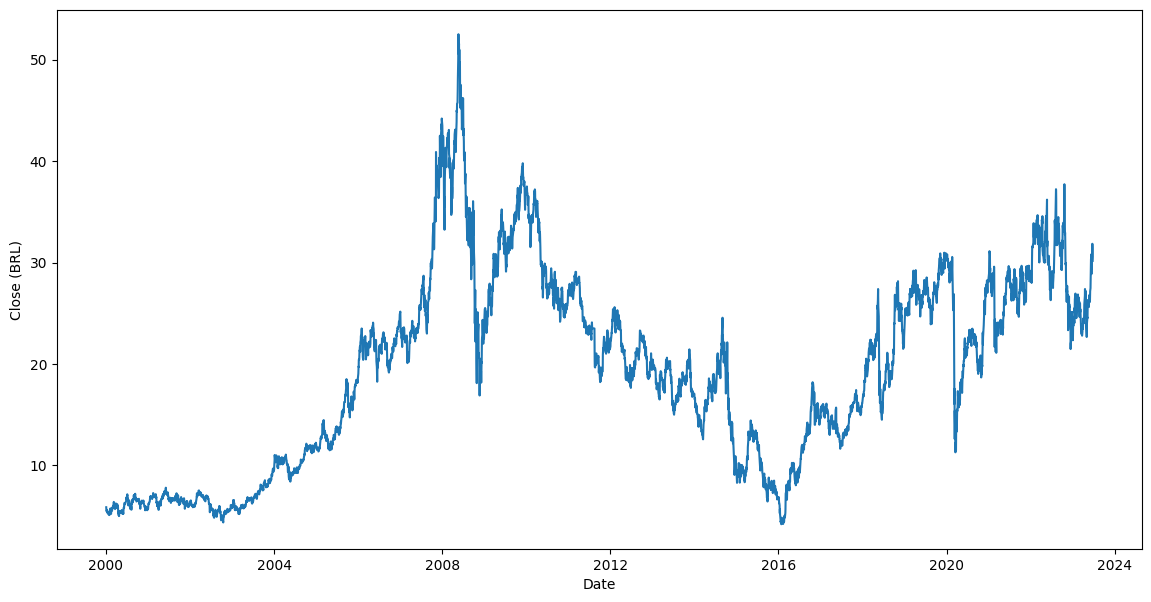

In [20]:
plt.figure(figsize=(14,7))
sns.lineplot(x='Date', y='Close', data=df)
plt.ylabel('Close (BRL)')

In [6]:
df = pd.read_csv('data/PETR4.SA.csv', parse_dates=['Date'], index_col='Date')
df["Diff"] = df.Close.diff()
df["SMA_2"] = df.Close.rolling(2).mean()
df["Force_Index"] = df["Close"] * df["Volume"]
df["y"] = df["Diff"].apply(lambda x: 1 if x > 0 else 0).shift(-1)

df = df.drop(["Open", "High", "Low", "Close", "Volume", "Diff", "Adj Close"], axis=1).dropna()



X = df.drop(["y"], axis=1).values
y = df["y"].values
X_train, X_test, y_train, y_test = train_test_split(
   X,
   y,
   test_size=0.25,
   shuffle=False,
)
clf = make_pipeline(StandardScaler(), MLPClassifier(max_iter=400, learning_rate='adaptive', random_state=0, shuffle=False, activation='tanh', solver='adam'))
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
y_train_pred = clf.predict(X_train)
print(accuracy_score(y_train, y_train_pred))
print(accuracy_score(y_test, y_pred))

0.5108597285067873
0.4796472184531886


In [ ]:
df = pd.read_csv('data/petro.csv', parse_dates=['Date'], index_col='Date')
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Price,120.0,28.955583,2.181511,25.34,27.3325,28.970,29.9625,35.68
Open,120.0,28.891833,2.110336,25.32,27.2000,28.970,29.8800,35.34
High,120.0,29.367917,2.154804,25.75,27.7075,29.470,30.2675,35.85
Low,120.0,28.470000,2.108251,25.21,26.9050,28.605,29.4975,34.76


In [ ]:
df.head()

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2023-06-23,33.90,34.82,34.87,33.42,11.74M,-3.39%
2023-06-22,35.09,35.34,35.49,34.76,13.63M,-1.65%
2023-06-21,35.68,34.73,35.85,34.64,16.98M,3.99%
2023-06-20,34.31,34.08,34.40,33.46,20.06M,0.26%
2023-06-19,34.22,33.39,34.24,33.29,5.67M,2.49%


In [ ]:
df = df[['Price', 'Vol.']]

In [ ]:
df.head(3)

,Price,Vol.
Date,,
2023-06-23,33.90,11.74M
2023-06-22,35.09,13.63M
2023-06-21,35.68,16.98M


In [ ]:
df['Vol.'] = df['Vol.'].str.replace('M', '').astype('float64')*10**6
df.info()
df.dropna(inplace=True)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 120 entries, 2023-06-23 to 2023-01-02
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Price   120 non-null    float64
 1   Vol.    119 non-null    float64
dtypes: float64(2)
memory usage: 2.8 KB


/tmp/ipykernel_8154/1359166843.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Vol.'] = df['Vol.'].str.replace('M', '').astype('float64')*10**6
/tmp/ipykernel_8154/1359166843.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(inplace=True)


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 119 entries, 2023-06-23 to 2023-01-02
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Price   119 non-null    float64
 1   Vol.    119 non-null    float64
dtypes: float64(2)
memory usage: 2.8 KB


<Axes: xlabel='Date', ylabel='Price'>

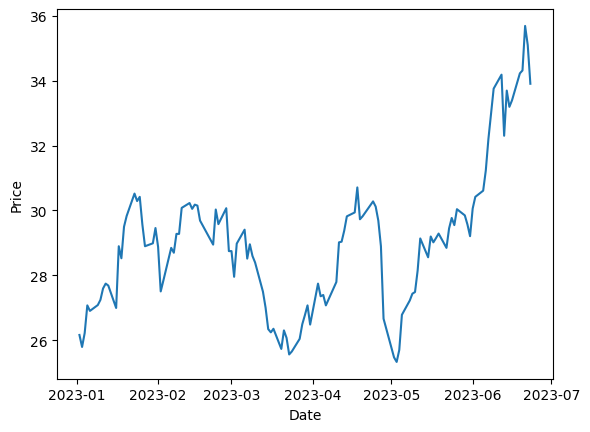

In [ ]:
sns.lineplot(x='Date', y='Price', data=df)

In [ ]:
df.head()

,Price,Vol.
Date,,
2023-06-23,33.90,11740000.0
2023-06-22,35.09,13630000.0
2023-06-21,35.68,16980000.0
2023-06-20,34.31,20060000.0
2023-06-19,34.22,5670000.0


continue with a time series while await response

In [ ]:
# Generate sample data for training
X = np.random.rand(100, 5)  # Input features (e.g., historical demand, price, etc.)
y = np.random.rand(100)     # Target variable (e.g., demand)

# Scale the input features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Create and train the MLPRegressor model
model = MLPRegressor(hidden_layer_sizes=(10, 10), activation='relu', solver='adam', random_state=42)
model.fit(X_train, y_train)

# Evaluate the model
score = model.score(X_test, y_test)
print(f"R^2 Score: {score}")

# Make predictions on new data
new_data = np.random.rand(5)  # New input features
new_data_scaled = scaler.transform(new_data.reshape(1, -1))
prediction = model.predict(new_data_scaled)
print(f"Predicted demand: {prediction}")

R^2 Score: -0.15759178213164926
Predicted demand: [0.39117564]


In [ ]:
y.shape

(100,)

In [ ]:
# Generate sample data for training
X = df[['Price']].values # Input features (e.g., historical demand, price, etc.)
y = df['Price']     # Target variable (e.g., demand)

# Scale the input features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Create and train the MLPRegressor model
model = MLPRegressor(hidden_layer_sizes=(50, 50), activation='relu', solver='adam', random_state=42)
model.fit(X_train, y_train)

# Evaluate the model
score = model.score(X_test, y_test)
print(f"R^2 Score: {score}")

# Make predictions on new data
new_data = pd.DataFrame()  # New input features
new_data_scaled = scaler.transform(new_data.reshape(1, -1))
prediction = model.predict(new_data_scaled)
print(f"Predicted demand: {prediction}")

R^2 Score: -6.482635456344343


/home/fmaron/.pyenv/versions/petropredict/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


ValueError: at least one array or dtype is required

array([33.9 , 35.09, 35.68, 34.31, 34.22, 33.39, 33.19, 33.69, 32.3 ,
       34.18, 33.75, 32.2 , 31.23, 30.61, 30.42, 30.06, 29.21, 29.57,
       29.85, 30.04, 29.55, 29.77, 29.45, 28.85, 29.29, 29.15, 29.02,
       29.2 , 28.56, 29.14, 28.15, 27.49, 27.44, 27.23, 26.79, 25.71,
       25.34, 25.48, 26.67, 28.9 , 29.69, 30.12, 30.28, 29.82, 29.73,
       30.71, 29.94, 29.82, 29.38, 29.04, 29.02, 27.8 , 27.08, 27.4 ,
       27.36, 27.75, 26.49, 27.08, 26.78, 26.5 , 26.05, 25.66, 25.57,
       26.08, 26.31, 25.74, 26.36, 26.25, 26.35, 27.01, 27.5 , 28.4 ,
       28.6 , 28.96, 28.52, 29.41, 28.98, 27.96, 28.75, 28.75, 30.07,
       29.58, 30.03, 28.95, 29.69, 30.15, 30.18, 30.05, 30.23, 30.08,
       29.28, 29.28, 28.7 , 28.85, 27.84, 27.51, 28.88, 29.46, 28.99,
       28.9 , 29.57, 30.42, 30.29, 30.52, 29.83, 29.5 , 28.53, 28.9 ,
       27.  , 27.69, 27.75, 27.6 , 27.25, 27.09, 26.91, 27.08, 26.23,
       25.8 , 26.17])